In [1]:
import timeit
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import boto3
import awswrangler as wr

from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.inspection import DecisionBoundaryDisplay
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from mpl_toolkits.mplot3d import Axes3D

In [2]:
boto3.setup_default_session(profile_name='datasci')

In [3]:
q = f"""
SELECT post_evar3, browser_type, OS as brows_os, page_event_var2, missing_prod_view, page_error, excluded_hit_error
    , visit_num, hit_time_gmt, page_load_time, sum(error_pv_factor + page_error_factor + page_load_time_factor + excluded_hit_error_factor) as error_factor
FROM (
SELECT case when post_evar3 is not null then post_evar3 else 'None' end as post_evar3
    , case when b_type.col1 is not null then b_type.col1 else 'None' end as browser_type
    , case when os.col1 is not null then os.col1 else 'None' end as OS
    , case when post_page_event_var2 is not null then post_page_event_var2 else 'None' end as page_event_var2
    , case when post_event_list not like '%,201,%' then 1 else 0 end as missing_prod_view
    , case when post_event_list like '%,203,%' then 1 else 0 end as page_error
    , case when exclude_hit = '0' then 0 else 1 end as excluded_hit_error
    , visit_num, visit_page_num, hit_time_gmt, try_cast(post_prop68 as bigint) as page_load_time
    
    , case when post_event_list like '%,201,%' then 0 else 10 end as error_pv_factor
    , case when exclude_hit = '0' then 0 else 10 end as excluded_hit_error_factor
    , case when post_event_list not like '%,203,%' then 0 else 1000 end as page_error_factor
    , case when try_cast(post_prop68 as bigint) > 15000 then 100 else 0 end as page_load_time_factor
FROM "us_clickstream_prod"."daily" 
left join "us_clickstream_prod"."browser_type" as b_type
    on try_cast(daily.browser as bigint) = b_type.col0
left join "us_clickstream_prod"."operating_systems" as os
    on try_cast(daily.os as bigint) = os.col0
where page_url like 'https://www.landsend.com/products/%'
    and post_prop68 is not null
    and try_cast(post_prop68 as bigint) < 30000
    and year = '2024'
    and month = '10' 
    and day = '8'
)
group by 1,2,3,4,5,6,7,8,9,10
"""

In [4]:
df = wr.athena.read_sql_query(
    q,
    database="us_clickstream_prod", 
    s3_output = "s3://lerawzone/users/acscies/athena/"
)

In [5]:
starting_outlier_prct = df.query('error_factor > 0')['error_factor'].count() / df['error_factor'].count()
print("The outlier fraction before inserting anomolies is:")
starting_outlier_prct

The outlier fraction before inserting anomolies is:


0.006029541765694742

In [6]:
min_hit_time = df['hit_time_gmt'].min() 

In [7]:
#To insert some errors into the dataset and create simulation  
df_append = pd.DataFrame(columns=["post_evar3", "browser_type", "brows_os", "page_event_var2",
                                  "missing_prod_view", "page_error", "excluded_hit_error",
                                 "visit_num", "hit_time_gmt", "page_load_time", "error_factor"], dtype="int")
for i in range(10000):
    hit_time_gmt = (min_hit_time + i)
    df_values = ['external campaign', 'Google', 'None', 'None', 1, 1, 1, 1, hit_time_gmt, 35000, 999] 
    df_append.loc[len(df_append.index)] = df_values

In [8]:
df = pd.concat([df, df_append])

In [9]:
df.reset_index()
df.tail()

,post_evar3,browser_type,brows_os,page_event_var2,missing_prod_view,page_error,excluded_hit_error,visit_num,hit_time_gmt,page_load_time,error_factor
9995,external campaign,Google,None,None,1,1,1,1,1728373595,35000,999
9996,external campaign,Google,None,None,1,1,1,1,1728373596,35000,999
9997,external campaign,Google,None,None,1,1,1,1,1728373597,35000,999
9998,external campaign,Google,None,None,1,1,1,1,1728373598,35000,999
9999,external campaign,Google,None,None,1,1,1,1,1728373599,35000,999


In [10]:
df.isnull().values.any()

False

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114064 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   post_evar3          1114064 non-null  object
 1   browser_type        1114064 non-null  object
 2   brows_os            1114064 non-null  object
 3   page_event_var2     1114064 non-null  object
 4   missing_prod_view   1114064 non-null  Int64 
 5   page_error          1114064 non-null  Int64 
 6   excluded_hit_error  1114064 non-null  Int64 
 7   visit_num           1114064 non-null  Int64 
 8   hit_time_gmt        1114064 non-null  Int64 
 9   page_load_time      1114064 non-null  Int64 
 10  error_factor        1114064 non-null  Int64 
dtypes: Int64(7), object(4)
memory usage: 109.4+ MB


In [12]:
#drop columns that won't help
df = df.drop(columns=['brows_os', 'post_evar3', 'page_event_var2'])

In [13]:
#create testing DF 
auto_forest_df = df[['browser_type', 'page_load_time', 'visit_num', 'hit_time_gmt',
                'page_error', 'excluded_hit_error', 'visit_num',  'error_factor']]


auto_forest_df.head()

,browser_type,page_load_time,visit_num,hit_time_gmt,page_error,excluded_hit_error,visit_num,error_factor
0,Google,5522,9,1728415086,0,0,9,0
1,None,597,169,1728424689,0,0,169,0
2,None,4156,1,1728429198,0,0,1,0
3,Mozilla,7436,1,1728366783,0,0,1,0
4,Google,1239,2,1728404131,0,0,2,0


In [14]:
print("Isolation Forest Using Auto for Contamination")

Isolation Forest Using Auto for Contamination


In [15]:
auto_isoforest = auto_forest_df.drop(columns=['browser_type','error_factor'])

In [16]:
#Test with contamination='auto'
auto_clf=IsolationForest(contamination='auto', max_features=2, random_state=42)
auto_clf.fit(auto_isoforest)
auto_forest_df['anomaly'] = auto_clf.predict(auto_isoforest)
auto_forest_df['scores'] = auto_clf.decision_function(auto_isoforest)

/tmp/ipykernel_439/1508105398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_forest_df['anomaly'] = auto_clf.predict(auto_isoforest)
/tmp/ipykernel_439/1508105398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_forest_df['scores'] = auto_clf.decision_function(auto_isoforest)


In [17]:
auto_counts = auto_forest_df.anomaly.value_counts()
#True positive outliers
auto_tp_outlier = auto_forest_df.query('error_factor > 0 and anomaly == -1')['error_factor'].count()
#False positive outliers
auto_fp_outlier = auto_forest_df.query('error_factor == 0 and anomaly == -1')['error_factor'].count()
#True positive inliers
auto_tp_inlier = auto_forest_df.query('error_factor == 0 and anomaly == 1')['error_factor'].count()
#False positive inliers
auto_fp_inlier = auto_forest_df.query('error_factor > 0 and anomaly == 1')['error_factor'].count()
#Very strong anomoly true positive and false negative outliers
auto_strong_tp_outlier = auto_forest_df.query('error_factor == 999 and anomaly == -1')['error_factor'].count()
auto_strong_fp_inliers = auto_forest_df.query('error_factor == 999 and anomaly == 1')['error_factor'].count()

In [18]:
print("Isolation Forest Using outlier_prct Contamination")

Isolation Forest Using outlier_prct Contamination


In [19]:
#create testing DF 
forest_df = df[['browser_type', 'page_load_time', 'visit_num', 'hit_time_gmt',
                'page_error', 'excluded_hit_error', 'visit_num',  'error_factor']]


forest_df.head()

,browser_type,page_load_time,visit_num,hit_time_gmt,page_error,excluded_hit_error,visit_num,error_factor
0,Google,5522,9,1728415086,0,0,9,0
1,None,597,169,1728424689,0,0,169,0
2,None,4156,1,1728429198,0,0,1,0
3,Mozilla,7436,1,1728366783,0,0,1,0
4,Google,1239,2,1728404131,0,0,2,0


In [20]:
outlier_prct = df.query('error_factor > 0')['error_factor'].count() / df['error_factor'].count()
print("The outlier fraction after inserting anomolies is:")
outlier_prct

The outlier fraction after inserting anomolies is:


0.014951564721595886

In [21]:
isoforest = forest_df.drop(columns=['browser_type','error_factor'])

In [22]:
clf=IsolationForest(contamination=outlier_prct, random_state=42)
clf.fit(isoforest)
forest_df['anomaly'] = clf.predict(isoforest)
forest_df['scores'] = clf.decision_function(isoforest)

/usr/local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_439/2091488954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_df['anomaly'] = clf.predict(isoforest)
/tmp/ipykernel_439/2091488954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_df['scores'] = clf.decision_function(isoforest)


In [23]:
inlier, outlier = forest_df.loc[forest_df.anomaly==1], forest_df.loc[forest_df.anomaly==-1]

In [24]:
counts = forest_df.anomaly.value_counts()
#True positive outliers
tp_outlier = forest_df.query('error_factor > 0 and anomaly == -1')['error_factor'].count()
#False positive outliers
fp_outlier = forest_df.query('error_factor == 0 and anomaly == -1')['error_factor'].count()
#True positive inliers
tp_inlier = forest_df.query('error_factor == 0 and anomaly == 1')['error_factor'].count()
#False positive inliers
fp_inlier = forest_df.query('error_factor > 0 and anomaly == 1')['error_factor'].count()
#Very strong anomoly true positive and false negative outliers
strong_tp_outlier = forest_df.query('error_factor == 999 and anomaly == -1')['error_factor'].count()
strong_fp_inliers = forest_df.query('error_factor == 999 and anomaly == 1')['error_factor'].count()

In [25]:
print("Actual pre-identified outliers:")
df.query('error_factor > 0')['error_factor'].count()

Actual pre-identified outliers:


16657

In [26]:
print("auto_counts:")
print(auto_counts)
print("\nauto tp outlier and fp outlier:")
print(auto_tp_outlier)
print(auto_fp_outlier)
print("\nauto tp inlier and fp inlier:")
print(auto_tp_inlier)
print(auto_fp_inlier)
print("\nauto strong tp outlier and FP inliers:")
print(auto_strong_tp_outlier)
print(auto_strong_fp_inliers)

auto_counts:
 1    1012046
-1     102018
Name: anomaly, dtype: int64

auto tp outlier and fp outlier:
12019
89999

auto tp inlier and fp inlier:
1007408
4638

auto strong tp outlier and FP inliers:
10000
0


In [27]:
print("counts:")
print(counts)
print("\ntp outlier and fp outlier:")
print(tp_outlier)
print(fp_outlier)
print("\ntp inlier and fp inlier:")
print(tp_inlier)
print(fp_inlier)
print("\nstrong tp outlier and FP inliers:")
print(strong_tp_outlier)
print(strong_fp_inliers)

counts:
 1    1097411
-1      16653
Name: anomaly, dtype: int64

tp outlier and fp outlier:
10177
6476

tp inlier and fp inlier:
1090931
6480

strong tp outlier and FP inliers:
10000
0


In [28]:
df_1 = forest_df.loc[:, ['browser_type', 'anomaly']]

In [29]:
#for anomoly % by browswer type
df_1[df_1["anomaly"]== -1].groupby('browser_type').count() / df_1[df_1["anomaly"]== 1].groupby('browser_type').count()

,anomaly
browser_type,
AOL,NaN
Amazon,NaN
Apple,0.002637
Google,0.043987
Microsoft,NaN
Mozilla,0.009520
None,0.007758
Opera,NaN
Other,NaN


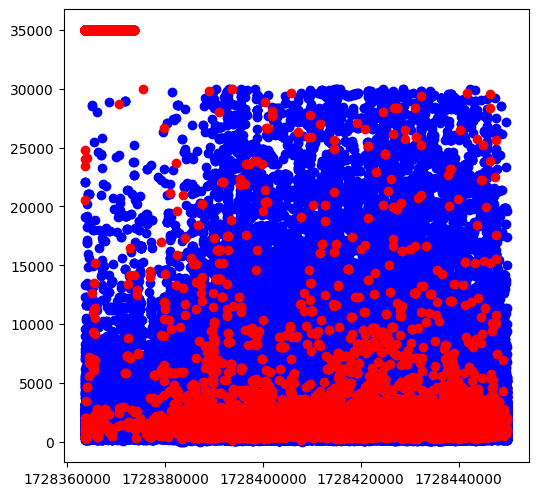

In [30]:
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(inlier.hit_time_gmt, inlier.page_load_time, label="inliers", c ="blue")
plt.scatter(outlier.hit_time_gmt, outlier.page_load_time, label="outliers", c ="red")
plt.ticklabel_format(style='plain')
plt.ticklabel_format(useOffset=False)
plt.show()